# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Advanced-Sections: Homework 1 - Transfer Learning




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os
# For colab: Import the TF V2 through this magic command
# %tensorflow_version 2.x 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

#import keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.0.0


<div class="theme"> Overview </div> 


**How to use existing models for transfer learning:**
Transfer learning is a Machine Learning method where we use the knowledge gained while solving a problem to solve another problem. For instance, when the training data is too small to train a deep network, we can load a pre-trained network and then fine-tuning a few of its parameters by using our small training set.
In this homework you will be engaged with two usefull applications of transfer learning. (a) Train a deep network with a small dataset. (b) Improve the feature extraction of a pre-train deep network. In particular, the aim of the homework is:
- Learn the idea of transfer learning through a simple classification example
- Build  new networks by using pre-trained models. Combine  pre-trained layers with new layers, and train specific layers.
- Get good  performance of image classification and feature extraction by training with small datasets.


The task of this homework is to design a network for classifying and extracting features for two different categories:  dogs and flowers.  The pre-trained model that  will be used is the *MobileNet* which is trained in 1000 categories with 1000 images per category. Although this pre-trained model classifies and extract features from 1000 categories pretty well, there are some other categories that the pre-trained MobileNet does not perform very well. In this homework, we will improve the performance, namely the classification and the feature extraction abilities of the MobileNet on those categories. 

----------


<div class='exercise'><b> Question 1: Load and inspect the pre-trained MobileNet  [40pts total] </b></div>


In this question, we have to load the pre-train the MobileNet. Then use the images and perfrom some classifications. Check whether the MobileNet classifies well and whether it is not. Afterwards, you need to make a deeper investigation. In particular, explore the feature maps extracted by the MobileNet. In this task you need to use the Principal Component Analysis method (PCA) to visualize the abstract feature maps space. 

**1.1. [10pts]**  Load a pre-trained MobileNet and inspect its performance in some of the images from the given `trainData`, or `testData`, or `pcaData` sets (these are new data for the pretrained MobileNet). Is the performance similar for all the  categories?


Set the directory where the dataset are located with the name `pathFolder`

In [3]:
#your code here
pathFolder = 'data/'

Check that the pathFolder is correct by showing the following image

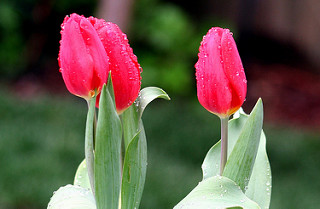

In [4]:
Image(filename= pathFolder + 'trainData/tulips/100930342_92e8746431_n.jpg')

Load the pre-train MobileNet trained in the `imagenet` dataset

In [5]:
#your code here
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')

Inspect the MobileNet architecture and define the image size as `IMG_SIZE` and the input shape as `IMG_SHAPE`

In [6]:
#your code here
mobile.summary()
IMG_SIZE = 224
IMG_SHAPE = (224,224,3)

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

**Three helper functions**

`prepare_image`: A function to prepare the images for the MobileNet. Input shape: (1, 224, 224, 3)

In [7]:
def prepare_image(img_path, img_size = 224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

`mobileClassifier`: A helper function for doing the classification by using MobileNet

In [8]:
def mobileClassifier(imagePath, pathFolder=pathFolder, mobile=mobile):
    imagePathFull = pathFolder + imagePath
    preprocessed_image = prepare_image(imagePathFull)
    # Use mobileNet to classify the image
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
#print(results)
    return results

`Prepare the data`

Load the data into the ImageDataGenerator. You might want to use  data augmentation:

 https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 


In [9]:
# this is a function to avoid reading secret directory. You might also need it later
filter_hidden = lambda my_list: [x for x in my_list if not x.startswith('.')]


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                                 horizontal_flip=True, 
                                                 rotation_range=45, 
#                                                 zoom_range=[0.8,1.0]
                                ) 

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 


# TRAINING set
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = filter_hidden(os.listdir(pathTrain)) # the directory path

# TESTING set
pathTest = pathFolder + 'testData/'
listGroupsTest = filter_hidden(os.listdir(pathTest)) # the directory path

# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathTrain,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)


test_generator=test_datagen.flow_from_directory(pathTest,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTrain)

Found 843 images belonging to 5 classes.
Found 104 images belonging to 5 classes.


Classify some of the images. Choose images from different categories

In [10]:

print('Predicting A German Shepards:')

mobileClassifier('/testData/German_Shepherd/41.16810631481_9a7baf6f25_z.jpg')


Predicting A German Shepards:


[[('n02094258', 'Norwich_terrier', 0.3613295),
  ('n02096294', 'Australian_terrier', 0.22394587),
  ('n02094433', 'Yorkshire_terrier', 0.09887189),
  ('n02096177', 'cairn', 0.0928132),
  ('n02093754', 'Border_terrier', 0.051211506)]]

In [11]:
#your code here

print('Predicting A Labrador:')

mobileClassifier('/testData/labrador/34.labrador-retriever-02.jpg')


Predicting A Labrador:


[[('n02099712', 'Labrador_retriever', 0.9825105),
  ('n02099601', 'golden_retriever', 0.0058766655),
  ('n02087394', 'Rhodesian_ridgeback', 0.0053968728),
  ('n02099267', 'flat-coated_retriever', 0.0012521298),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.000988808)]]

In [12]:
#your code here
#your code here

print('Predicting A Daisy:')

mobileClassifier('/testData/daisy/2666572212_2caca8de9f_n.jpg')


Predicting A Daisy:


[[('n11939491', 'daisy', 0.98896295),
  ('n02280649', 'cabbage_butterfly', 0.00197019),
  ('n02206856', 'bee', 0.0016742279),
  ('n02279972', 'monarch', 0.001010929),
  ('n12057211', "yellow_lady's_slipper", 0.00078750314)]]

#### Your comments here:
It's interesting how the for daisy and labrador, the probabilities are very high and the classification is correct, while the classification for the german shepard was incorrect and the probabilities are much lower. Mobile-net must be better at classifying some things or types of things than others, though I do not know what falls into that criteria. Another point of note is that the other items of lower probabilities for the daisy are bugs, which makes me feel a bit less confident in it's ability to distinguish flowers.

**1.2. [15pts]** Explore the feature maps extracted by the pre-train MobileNet. In particular, extract the features that MobileNet learns for three images, one from each category of dogs and flowers.
 
First, prepare the two images from each category

In [13]:
# your code here
test_gs = prepare_image(
    pathFolder+'/testData/German_Shepherd/41.16810631481_9a7baf6f25_z.jpg')

test_lab = prepare_image(
    pathFolder+'/testData/labrador/34.labrador-retriever-02.jpg')

test_daisy = prepare_image(
    pathFolder+'/testData/daisy/2666572212_2caca8de9f_n.jpg')


Inspect the first convolution layer: `conv1`. Exctract and plot the first five features maps of each image.

Hint: Load only up to the first convolution layer. Use `summary()` to check the name of the layer.


shape:  (1, 112, 112, 32) 

type:  <class 'numpy.ndarray'> 



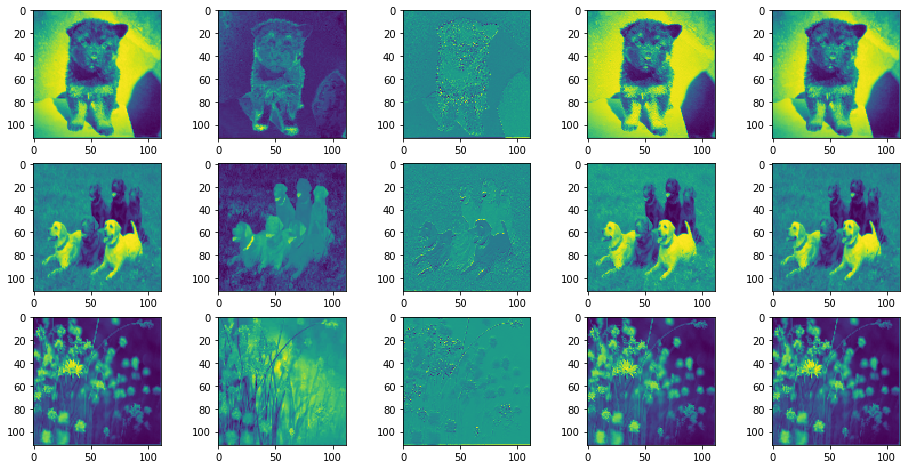

In [14]:
#your code here
# Code via TransferLearning Computefest Workshop by Marios

# load the model up to first convolution layers
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv1').output)

features1 = inspectLayerModel.predict(test_gs)
features2 = inspectLayerModel.predict(test_lab)
features3 = inspectLayerModel.predict(test_daisy)

print('shape: ', features1.shape , '\n')
print('type: ',type(features1), '\n')

# Plot the first N features for each image
N=5
plt.figure(figsize=[16,8])
for i in range(N):
    # i in a different feature of each imge
    plt.subplot(3,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(3,N,N+i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(3,N,2*N + i+1)
    plt.imshow(features3[0,:,:,i])

Inpsect the last 2D convolution layer: `conv_pw_13`. Exctract and plot the first five features maps of each image.

shape:  (1, 7, 7, 1024) 

type:  <class 'numpy.ndarray'> 



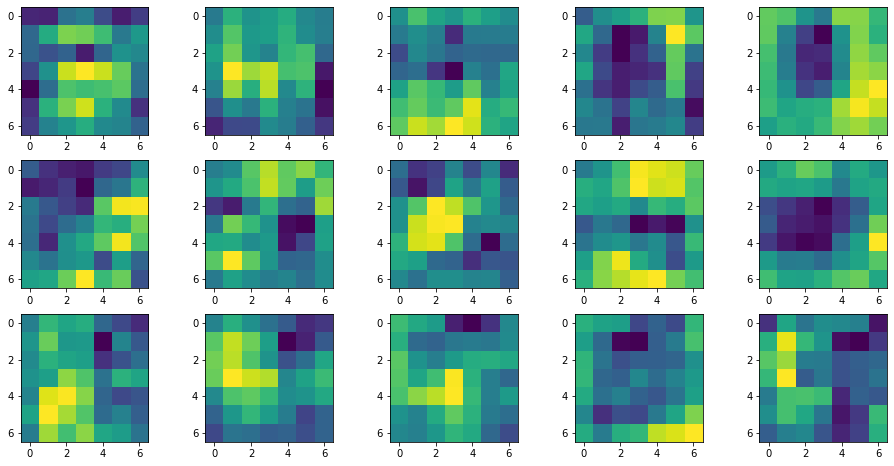

In [15]:
#your code here
# Code via TransferLearning Computefest Workshop by Marios
# load the model up to first convolution layers
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13').output)

features1 = inspectLayerModel.predict(test_gs)
features2 = inspectLayerModel.predict(test_lab)
features3 = inspectLayerModel.predict(test_daisy)

print('shape: ', features1.shape , '\n')
print('type: ',type(features1), '\n')

# Plot the first N features for each image
N=5
plt.figure(figsize=[16,8])
for i in range(N):
    # i in a different feature of each imge
    plt.subplot(3,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(3,N,N+i+1)
    plt.imshow(features2[0,:,:,i])
    plt.subplot(3,N,2*N + i+1)
    plt.imshow(features3[0,:,:,i])


Can we draw any conclusions or understand anything from these feature maps? Obviously no. It is a very abstract representation. We can further investigate the feature maps by using **Principal Component Analysis (PCA)** method.

**1.3. [15pts]** Use PCA to study the extracted feature maps. In particular, perform a PCA transform for the extracted from the last convolution layer features.

To save some time you might use only 20 images per category. These data are store at `pcaData`.


Define the layer from which we  extract the features

In [16]:
#your code here
pcaLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13').output)


Two intermedia steps: (A)  Count the total images and the categories of the dataset that is located in the `pcaData` directory. (B)  Prepare the data for the PCA and assign the associate name of category of each image

In [17]:
#your code here
# location
pathPCA = pathFolder + 'pcaData/'

# groups
listGroups = os.listdir(pathPCA) # the directory path
number_groups = len(listGroups)

# count the pictures
totalImages = 0
for pathF in listGroups:
    pathF1 = pathPCA + pathF
    listFiles = os.listdir(pathF1) 
    totalImages += len(listFiles)

Perform PCA transform and keep  onlythe first two principal components

In [18]:
#your code here
# Code via TransferLearning Computefest Workshop by Marios

features_flatten = np.zeros([totalImages,7*7*1024]) 

i=0
for pathF in listGroups:
    pathF1 = pathPCA + pathF + "/"
    for imgName in os.listdir(pathF1):
        pathImag = pathF1 + imgName
        preprocessed_img = prepare_image(pathImag)
        features = pcaLayerModel.predict(preprocessed_img)
        features_flatten[i,:] = features.flatten()
        i += 1        
pca = PCA(n_components=2)
transferValues = features_flatten
transferVal_pca = pca.fit_transform(transferValues)

Plot the results obtained by PCA transform. Use different color/symbol to represent each of the categories.

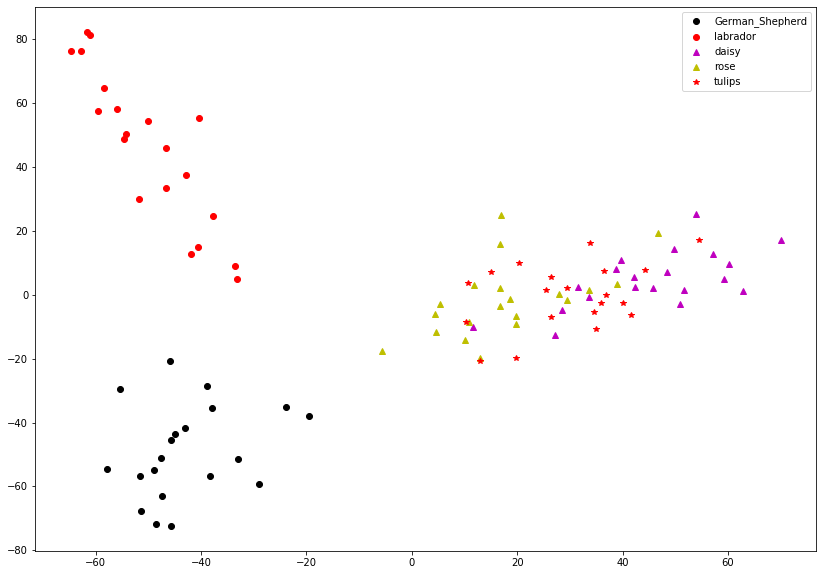

In [19]:
#your code here

x = transferVal_pca[:, 0]
y = transferVal_pca[:, 1]

mystyle = ['ok', 'or','^m','^y','*r','*k', '*b','ob']

plt.figure(figsize=[14,10])

# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();

From the top to PCs plotted above, I can see that here is clear clustering for labradors and german shepard's, but that things are a lot more muddled up for the different types of flowers. This doesn't necessarily follow the conclusions from the previous problem, but perhaps speaks to the unique characteristics that dog's show, and that perhaps flowers have fewer of those. It would thus follow that generally, the probability of classification for a GS or Lab would be much higher than a flower, given the lack of distinction.

<div class='exercise'><b> Question 2: Improve the classification ability of the pre-trained MobileNet  [30pts total] </b></div>



How can we improve the MobileNet?

The pre-trained MobileNet architecture shows quite good performance. Nevertheless, we want to improve  its classification ability  on the class of flowers. 
Training the MobileNet from  scratch by using only images  for dogs and flowers  will be overfitting because our dataset is too small and the network very expressive. So, let's use *transfer learning*.

 Use the pre-trained model and re-train just a few layers (fast and efficient).
 Since the convolution layers of the MobileNet can extract  abstract features from the images we can use (transfer) this knowledge by  freezing the convolution pre-trained layers. In particular, we can adjust and train one or a few new layers to classify the new data from the extracted features


**2.1. [15pts] Add and train a new dense layer on the top of the pre-trained MobileNet**


Use all the pre-trained convolution layers obtained by MobileNet (`base` model) and adjust one new dense layer in the end (`head`). Then, freeze the base layers and train only the fully connected layer. 

Define the base model

In [20]:
#your code here
transferModel_base = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

Create the new architecture by transfering the convolutions layers from the MobileNet. The name of the new architecture should be  `mobile_tl`.


In [21]:
#your code here
# Code via TransferLearning Computefest Workshop by Marios
transferModel_base.trainable = False

# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
number_groupsTrain = len(listGroupsTrain)

mobile_tl = tf.keras.Sequential([
      transferModel_base,
      tf.keras.layers.GlobalAveragePooling2D(),
      Dense(1024, activation='relu'),
      Dropout(0.2),
      Dense(512, activation='relu'),
      Dense(number_groupsTrain, activation='softmax', name="dense_head",
                                 kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                 bias_regularizer=tf.keras.regularizers.l1(bias_weight))
])
mobile_tl.compile(optimizer='adam',
                     loss='categorical_crossentropy' ,metrics=['accuracy'])


**2.2. [15pts] Compile the model and show the perfrormance of the new model**

Define an optimizer, the loss function, regularization, and the number of training period (epochs).  
To inspect the network performance after the training, you might store the Loss functions and the accuracy.
For the specific example, the validation loss should be less than 1 and the accuracy on the validation set should be at least 80%. A training between five and ten epochs should be fine.


In [22]:
#your code here
history_mobile_tl = mobile_tl.fit_generator(generator=train_generator,
                                       validation_data=test_generator,
                                       epochs=10)

Epoch 1/10
14/14 [==============================] - 22s 2s/step - loss: 3.9309 - accuracy: 0.5955 - val_loss: 3.7446 - val_accuracy: 0.6923
Epoch 2/10
14/14 [==============================] - 19s 1s/step - loss: 2.6668 - accuracy: 0.8422 - val_loss: 3.1067 - val_accuracy: 0.6250
Epoch 3/10
14/14 [==============================] - 19s 1s/step - loss: 2.1720 - accuracy: 0.8944 - val_loss: 2.4604 - val_accuracy: 0.7212
Epoch 4/10
14/14 [==============================] - 20s 1s/step - loss: 1.8174 - accuracy: 0.9253 - val_loss: 1.9782 - val_accuracy: 0.7788
Epoch 5/10
14/14 [==============================] - 19s 1s/step - loss: 1.5478 - accuracy: 0.9087 - val_loss: 1.6153 - val_accuracy: 0.7788
Epoch 6/10
14/14 [==============================] - 18s 1s/step - loss: 1.2926 - accuracy: 0.9146 - val_loss: 1.5624 - val_accuracy: 0.7500
Epoch 7/10
14/14 [==============================] - 20s 1s/step - loss: 1.0181 - accuracy: 0.9442 - val_loss: 1.4957 - val_accuracy: 0.6923
Epoch 8/10
14/14 [==

In [23]:
mobile_tl.evaluate(test_generator)

2/2 [==============================] - 5s 3s/step - loss: 0.9930 - accuracy: 0.7692


[0.9929866194725037, 0.7692308]

Note the test accuracy of roughly 80% (76.9)

Plot the loss and the accuracy for training and validation

In [24]:
def plot_history(histories, titles, clrs='red'):
    # helper function to plot the loss and accuracy 
    plt.figure(figsize=(18, 7))
    # for history, title in zip(histories,titles):
    for history, title, clr in zip(histories,titles,clrs):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # color='green', marker='o', linestyle='dashed'
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(acc)+1), acc, color=clr, label='Training Accuracy: ' + title)
        plt.plot(range(1, len(acc)+1), val_acc, color=clr, linestyle='dashed', label='Validation Accuracy: ' + title)
        plt.legend()
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(acc)+1), loss, color=clr,  label='Training Loss: ' + title)
        plt.plot(range(1, len(acc)+1), val_loss, color=clr, linestyle='dashed', label='Validation Loss: ' + title)
        plt.legend()
        plt.ylabel('Cross Entropy')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
    plt.show()

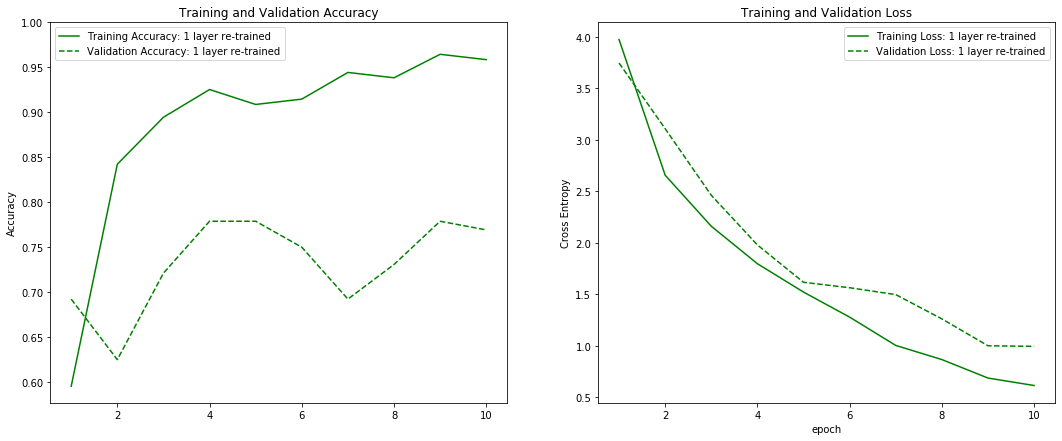

In [25]:
#your code here
histories = [history_mobile_tl]
titles = ['1 layer re-trained']
clrs = ['green']
plot_history(histories, titles, clrs)


<div class='exercise'><b> Question 3: Improve the extraction of the feature maps [30pts total] </b></div>


**3.1. [pts 15] Fine Tuning**

Take the previous based model and unfreeze the convolution layers. Create a new model with the base model and with the dense layer used in the `model_tl`. Then, train the entire network. Name the new model as `mobile_tuned`.

In [26]:
# #your code here
mobile_tuned = mobile_tl
mobile_tuned.trainable = True
# mobile_tuned.summary()



**3.2. [15pts] Compile the model, present the perfrormance of the new model, and visualize the feature maps with PCA**


In [27]:
#your code here

mobile_tuned.compile(optimizer='adam',
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
history_mobile_tuned = mobile_tuned.fit_generator(generator=train_generator,
                                       validation_data=test_generator,
                                       epochs=10)


Epoch 1/10
14/14 [==============================] - 21s 2s/step - loss: 1.2110 - accuracy: 0.8327 - val_loss: 9.1000 - val_accuracy: 0.1923
Epoch 2/10
14/14 [==============================] - 20s 1s/step - loss: 0.6398 - accuracy: 0.9063 - val_loss: 4.7858 - val_accuracy: 0.4808
Epoch 3/10
14/14 [==============================] - 21s 2s/step - loss: 0.4682 - accuracy: 0.9478 - val_loss: 8.7354 - val_accuracy: 0.2981
Epoch 4/10
14/14 [==============================] - 19s 1s/step - loss: 0.3954 - accuracy: 0.9656 - val_loss: 6.5129 - val_accuracy: 0.4231
Epoch 5/10
14/14 [==============================] - 22s 2s/step - loss: 0.5133 - accuracy: 0.9324 - val_loss: 0.7540 - val_accuracy: 0.7692
Epoch 6/10
14/14 [==============================] - 18s 1s/step - loss: 0.3910 - accuracy: 0.9561 - val_loss: 0.6293 - val_accuracy: 0.7885
Epoch 7/10
14/14 [==============================] - 20s 1s/step - loss: 0.3274 - accuracy: 0.9609 - val_loss: 0.7052 - val_accuracy: 0.8365
Epoch 8/10
14/14 [==

Visualize the performance (in comparison with the `mobile_tl`) and make some comments

In [28]:
mobile_tuned.evaluate(test_generator)

2/2 [==============================] - 4s 2s/step - loss: 0.3981 - accuracy: 0.9519


[0.39808568358421326, 0.9519231]

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


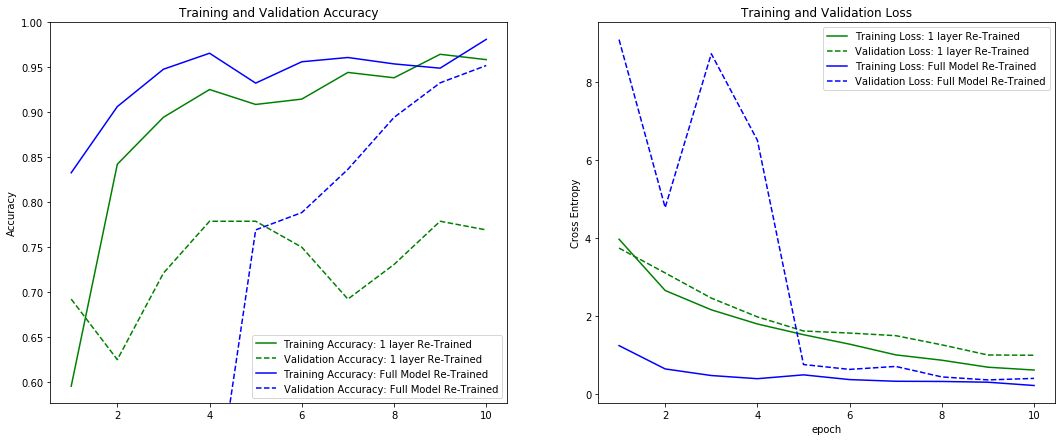

In [29]:
#your code here
histories = [history_mobile_tl, history_mobile_tuned]
titles = ['1 layer Re-Trained', 'Full Model Re-Trained']
clrs = ['green', 'blue']
plot_history(histories, titles, clrs)


#### Your comments here:

I am able to improve performance by retraining the whole model, which makes sense, as I am able to tweak the weights of mobile-net for my specific data. However, doing so is also more computationally intensive as I am training many more weights than I was when i froze the entire model. As such, often it makes sense to only freeze the last few layers.

IT should be noted that when retraining the whole model, I still have the benefit of the existing weights from Mobile-Net, and creating a model and weights from scratch would be much more computationally intensive than retraining. 

**Investigate the feature extraction by using PCA**

As with above, I will extract the output of my model before the dense classification layer and do PCA on it

In [33]:
pcaLayerModel = tf.keras.models.Model(inputs=mobile_tuned.get_layer('mobilenet_1.00_224').get_layer('input_2').input, outputs=mobile_tuned.get_layer('mobilenet_1.00_224').get_layer('conv_pw_13_relu').output)
# mobile_tuned.summary()
# mobile_tuned.get_layer('mobilenet_1.00_224').summary()

In [34]:
#your code here
features_flatten_tuned = np.zeros([totalImages,7*7*1024]) 

i=0
for pathF in listGroups:
    pathF1 = pathPCA + pathF + "/"
    for imgName in os.listdir(pathF1):
        pathImag = pathF1 + imgName
        preprocessed_img = prepare_image(pathImag)
        features = pcaLayerModel.predict(preprocessed_img)
        features_flatten_tuned[i,:] = features.flatten()
        i += 1  
        
pca = PCA(n_components=2)
transferValues = features_flatten_tuned
transferVal_pca_tuned = pca.fit_transform(transferValues)


Visualize the results obtained by PCA

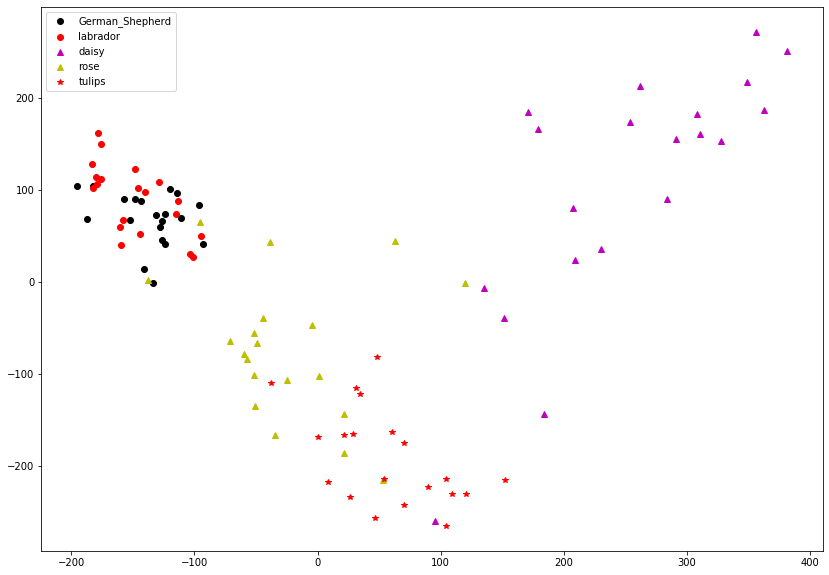

In [35]:
#your code here
#your code here

x = transferVal_pca_tuned[:, 0]
y = transferVal_pca_tuned[:, 1]

mystyle = ['ok', 'or','^m','^y','*r','*k', '*b','ob']

plt.figure(figsize=[14,10])

# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();

This PCA shows a lot better separation between the flowers, though now the dogs are very similar. Overall, though, this is a huge improvement from my previous clustering. This is a testament  to the power of transfer learning. However, it should be noted that in this case, I did continue retraining the full model to get better results. This is more computationally intensive, but can yield better results, given that you're starting from good weights.

#### Your comments here:


## **References**

- https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
- https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://arxiv.org/abs/1704.04861    

